In [1]:
# Data handling
import pandas as pd
import numpy as np

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, ClassifierMixin

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To make plots look nicer
plt.style.use("seaborn-v0_8")

In [2]:
# Custom Multinomial Naive Bayes for TF-IDF Text Classification

class CustomMultinomialNB(BaseEstimator, ClassifierMixin):
    """
    Custom implementation of Multinomial Naive Bayes classifier for text data.
    This implementation manually calculates priors and likelihoods for TF-IDF features.
    """
    
    def __init__(self, alpha=1.0):
        """
        Initialize the Custom Multinomial Naive Bayes classifier.
        
        Parameters:
        alpha (float): Laplace smoothing parameter to handle zero probabilities.
        """
        self.alpha = alpha
        self.priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.n_features = None
        
    def fit(self, X, y):
        """
        Train the Multinomial Naive Bayes classifier on TF-IDF features.
        
        Parameters:
        X (sparse matrix): Training TF-IDF features
        y (array-like): Training labels
        """
        print("=" * 60)
        print("TRAINING CUSTOM MULTINOMIAL NAIVE BAYES")
        print("=" * 60)
        
        # Convert sparse matrix to dense if needed for easier processing
        if hasattr(X, 'toarray'):
            X_dense = X.toarray()
        else:
            X_dense = np.array(X)
        
        y = np.array(y)
        self.classes = np.unique(y)
        self.n_features = X_dense.shape[1]
        
        print(f"Classes: {self.classes}")
        print(f"Number of features: {self.n_features}")
        print(f"Training samples: {len(y)}")
        
        # Step 1: Calculate Class Priors P(Class)
        print(f"\n--- Step 1: Calculating Class Priors ---")
        total_samples = len(y)
        
        for class_label in self.classes:
            class_count = np.sum(y == class_label)
            self.priors[class_label] = class_count / total_samples
            print(f"P({class_label}) = {class_count}/{total_samples} = {self.priors[class_label]:.4f}")
        
        # Step 2: Calculate Feature Log Probabilities P(Feature|Class)
        print(f"\n--- Step 2: Calculating Feature Probabilities ---")
        self.feature_log_probs = {}
        
        for class_label in self.classes:
            print(f"\nCalculating probabilities for class '{class_label}':")
            
            # Get samples for this class
            class_mask = (y == class_label)
            X_class = X_dense[class_mask]
            
            # Sum of all feature counts for this class (for normalization)
            class_feature_counts = np.sum(X_class, axis=0)  # Sum across samples
            total_features_in_class = np.sum(class_feature_counts)
            
            # Apply Laplace smoothing for each feature
            # P(feature_i | class) = (count_feature_i + alpha) / (total_features + alpha * vocab_size)
            smoothed_counts = class_feature_counts + self.alpha
            smoothed_total = total_features_in_class + self.alpha * self.n_features
            
            # Calculate log probabilities (to avoid numerical underflow)
            feature_probs = smoothed_counts / smoothed_total
            self.feature_log_probs[class_label] = np.log(feature_probs)
            
            print(f"  Total feature occurrences in class: {total_features_in_class}")
            print(f"  Vocabulary size: {self.n_features}")
            print(f"  Smoothing parameter (alpha): {self.alpha}")
            print(f"  Feature probabilities calculated with Laplace smoothing")
        
        print(f"\n=== Training Complete ===")
        return self
    
    def predict_log_proba(self, X):
        """
        Calculate log probabilities for each class.
        
        Parameters:
        X (sparse matrix): Test TF-IDF features
        
        Returns:
        log_probs: Log probabilities for each class
        """
        # Convert sparse matrix to dense if needed
        if hasattr(X, 'toarray'):
            X_dense = X.toarray()
        else:
            X_dense = np.array(X)
            
        n_samples = X_dense.shape[0]
        n_classes = len(self.classes)
        log_probs = np.zeros((n_samples, n_classes))
        
        for i, class_label in enumerate(self.classes):
            # Start with log prior
            log_prob = np.log(self.priors[class_label])
            
            # Add log likelihoods for all features
            # For multinomial NB: log P(x|c) = sum(x_i * log P(feature_i|c))
            class_log_probs = self.feature_log_probs[class_label]
            
            # Vectorized computation: X_dense @ class_log_probs
            feature_contributions = X_dense @ class_log_probs
            log_probs[:, i] = log_prob + feature_contributions
        
        return log_probs
    
    def predict_proba(self, X):
        """
        Predict class probabilities.
        
        Parameters:
        X (sparse matrix): Test features
        
        Returns:
        probabilities: Predicted probabilities for each class
        """
        log_probs = self.predict_log_proba(X)
        
        # Convert log probabilities to probabilities using softmax
        # Subtract max for numerical stability
        log_probs_stable = log_probs - np.max(log_probs, axis=1, keepdims=True)
        probs = np.exp(log_probs_stable)
        probs = probs / np.sum(probs, axis=1, keepdims=True)
        
        return probs
    
    def predict(self, X):
        """
        Predict class labels.
        
        Parameters:
        X (sparse matrix): Test features
        
        Returns:
        predictions: Predicted class labels
        """
        log_probs = self.predict_log_proba(X)
        predictions = np.argmax(log_probs, axis=1)
        return self.classes[predictions]
    
    def predict_single_detailed(self, X_sample, sample_text="", verbose=True):
        """
        Predict a single sample with detailed probability breakdown.
        
        Parameters:
        X_sample: Single TF-IDF vector
        sample_text: Original text (for display)
        verbose: Whether to show calculations
        
        Returns:
        prediction, probabilities
        """
        if hasattr(X_sample, 'toarray'):
            X_dense = X_sample.toarray().flatten()
        else:
            X_dense = np.array(X_sample).flatten()
        
        if verbose:
            print(f"\n--- Detailed Prediction ---")
            if sample_text:
                print(f"Text: '{sample_text[:100]}...'")
            print(f"TF-IDF vector shape: {X_dense.shape}")
            print(f"Non-zero features: {np.sum(X_dense > 0)}")
        
        log_probs = {}
        for class_label in self.classes:
            # Prior probability
            log_prior = np.log(self.priors[class_label])
            
            # Feature contributions
            feature_log_probs = self.feature_log_probs[class_label]
            feature_contribution = np.sum(X_dense * feature_log_probs)
            
            total_log_prob = log_prior + feature_contribution
            log_probs[class_label] = total_log_prob
            
            if verbose:
                print(f"\nClass '{class_label}':")
                print(f"  Log Prior: {log_prior:.4f}")
                print(f"  Feature Log Likelihood: {feature_contribution:.4f}")
                print(f"  Total Log Probability: {total_log_prob:.4f}")
        
        # Convert to regular probabilities
        log_values = np.array(list(log_probs.values()))
        log_values_stable = log_values - np.max(log_values)
        probs = np.exp(log_values_stable)
        probs = probs / np.sum(probs)
        
        prob_dict = dict(zip(self.classes, probs))
        prediction = max(prob_dict, key=prob_dict.get)
        
        if verbose:
            print(f"\nNormalized Probabilities:")
            for class_label, prob in prob_dict.items():
                print(f"  P({class_label}) = {prob:.4f}")
            print(f"Prediction: {prediction}")
        
        return prediction, prob_dict

print("Custom Multinomial Naive Bayes classifier implemented successfully!")

Custom Multinomial Naive Bayes classifier implemented successfully!


In [3]:
# Load the dataset
df = pd.read_csv("cleaned_reviews.csv")

# Quick check
print(df.shape)
print(df.head(4))


(5000, 3)
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   

                                      cleaned_review sentiment  
0  one of the other reviewers has mentioned that ...  positive  
1  a wonderful little production the filming tech...  positive  
2  i thought this was a wonderful way to spend ti...  positive  
3  basically there is a family where a little boy...  negative  


In [4]:
# Features (X) and Labels (y)
X = df["cleaned_review"]
y = df["sentiment"]

# 70/30 split with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Training size:", len(X_train))
print("Testing size:", len(X_test))
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))


Training size: 3500
Testing size: 1500

Train class distribution:
 sentiment
negative    0.506286
positive    0.493714
Name: proportion, dtype: float64

Test class distribution:
 sentiment
negative    0.506667
positive    0.493333
Name: proportion, dtype: float64


In [5]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# Fit on training data, transform train & test
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Shape of training data:", X_train_vec.shape)
print("Shape of testing data:", X_test_vec.shape)


Shape of training data: (3500, 10000)
Shape of testing data: (1500, 10000)


In [6]:
# Train the Custom Multinomial Naive Bayes classifier

# Initialize our custom Multinomial Naive Bayes classifier
custom_nb_model = CustomMultinomialNB(alpha=1.0)

# Train the model on the TF-IDF vectors of the training set
custom_nb_model.fit(X_train_vec, y_train)

print(f"\nCustom Multinomial Naive Bayes model training completed!")
print(f"Model trained on {len(y_train)} samples")
print(f"Classes: {list(custom_nb_model.classes)}")
print(f"TF-IDF vocabulary size: {custom_nb_model.n_features}")

TRAINING CUSTOM MULTINOMIAL NAIVE BAYES
Classes: ['negative' 'positive']
Number of features: 10000
Training samples: 3500

--- Step 1: Calculating Class Priors ---
P(negative) = 1772/3500 = 0.5063
P(positive) = 1728/3500 = 0.4937

--- Step 2: Calculating Feature Probabilities ---

Calculating probabilities for class 'negative':
  Total feature occurrences in class: 21085.01057508828
  Vocabulary size: 10000
  Smoothing parameter (alpha): 1.0
  Feature probabilities calculated with Laplace smoothing

Calculating probabilities for class 'positive':
Classes: ['negative' 'positive']
Number of features: 10000
Training samples: 3500

--- Step 1: Calculating Class Priors ---
P(negative) = 1772/3500 = 0.5063
P(positive) = 1728/3500 = 0.4937

--- Step 2: Calculating Feature Probabilities ---

Calculating probabilities for class 'negative':
  Total feature occurrences in class: 21085.01057508828
  Vocabulary size: 10000
  Smoothing parameter (alpha): 1.0
  Feature probabilities calculated with L

In [7]:
# Make predictions using our Custom Multinomial Naive Bayes

print("Making predictions on test set...")
y_pred = custom_nb_model.predict(X_test_vec)

print(f"Predictions completed for {len(y_pred)} test samples")

# Show detailed prediction for a few sample texts
print(f"\n--- Sample Detailed Predictions ---")
sample_indices = [0, 100, 200]  # Show predictions for 3 samples

for i, idx in enumerate(sample_indices):
    if idx < len(X_test):
        sample_text = X_test.iloc[idx]
        actual_label = y_test.iloc[idx]
        
        print(f"\nSample {i+1} (Index {idx}):")
        print(f"Original text: '{sample_text[:150]}...'")
        print(f"Actual sentiment: {actual_label}")
        
        pred, probs = custom_nb_model.predict_single_detailed(
            X_test_vec[idx], sample_text, verbose=True
        )
        
        status = "CORRECT" if pred == actual_label else "WRONG"
        print(f"Result: {status}")
        print("-" * 50)

Making predictions on test set...
Predictions completed for 1500 test samples

--- Sample Detailed Predictions ---

Sample 1 (Index 0):
Original text: 'i was unsure of this movie before renting and did so on the assurance that hilary swank has always given excellent performances in her movies she seem...'
Actual sentiment: positive

--- Detailed Prediction ---
Text: 'i was unsure of this movie before renting and did so on the assurance that hilary swank has always g...'
TF-IDF vector shape: (10000,)
Non-zero features: 174

Class 'negative':
  Log Prior: -0.6807
  Feature Log Likelihood: -105.0299
  Total Log Probability: -105.7105

Class 'positive':
  Log Prior: -0.7058
  Feature Log Likelihood: -103.8378
  Total Log Probability: -104.5435

Normalized Probabilities:
  P(negative) = 0.2374
  P(positive) = 0.7626
Prediction: positive
Result: CORRECT
--------------------------------------------------

Sample 2 (Index 100):
Original text: 'here we have the inimitable charlie chaplin forsak

In [8]:
# Comprehensive Performance Evaluation

print("=" * 70)
print("CUSTOM MULTINOMIAL NAIVE BAYES PERFORMANCE EVALUATION")
print("=" * 70)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOVERALL ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=custom_nb_model.classes)
print(f"\nCONFUSION MATRIX:")
print("-" * 40)
print("Actual vs Predicted:")
print(f"{'':>12} {'Predicted':>20}")
print(f"{'Actual':>8} {custom_nb_model.classes[0]:>10} {custom_nb_model.classes[1]:>10} {'Total':>8}")
print("-" * 40)

for i, actual_class in enumerate(custom_nb_model.classes):
    row_total = np.sum(cm[i, :])
    print(f"  {actual_class:>6}   {cm[i,0]:>10} {cm[i,1]:>10} {row_total:>8}")
print("-" * 40)

col_totals = np.sum(cm, axis=0)
total_samples = np.sum(cm)
print(f"{'Total':>8} {col_totals[0]:>10} {col_totals[1]:>10} {total_samples:>8}")

# Detailed classification report
print(f"\nDETAILED CLASSIFICATION REPORT:")
print("-" * 60)
print(classification_report(y_test, y_pred, digits=4))

# Calculate additional metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=custom_nb_model.classes)

print(f"PERFORMANCE METRICS BY CLASS:")
print("-" * 50)
print(f"{'Class':<10} {'Precision':<12} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")
print("-" * 50)

for i, class_label in enumerate(custom_nb_model.classes):
    print(f"{class_label:<10} {precision[i]:<12.4f} {recall[i]:<10.4f} {f1[i]:<10.4f} {support[i]:<8}")

# Calculate macro and weighted averages
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

weighted_precision = np.average(precision, weights=support)
weighted_recall = np.average(recall, weights=support)
weighted_f1 = np.average(f1, weights=support)

print("-" * 50)
print(f"{'Macro Avg':<10} {macro_precision:<12.4f} {macro_recall:<10.4f} {macro_f1:<10.4f} {np.sum(support):<8}")
print(f"{'Weighted Avg':<10} {weighted_precision:<12.4f} {weighted_recall:<10.4f} {weighted_f1:<10.4f} {np.sum(support):<8}")


CUSTOM MULTINOMIAL NAIVE BAYES PERFORMANCE EVALUATION

OVERALL ACCURACY: 0.8667 (86.67%)

CONFUSION MATRIX:
----------------------------------------
Actual vs Predicted:
                        Predicted
  Actual   negative   positive    Total
----------------------------------------
  negative          679         81      760
  positive          119        621      740
----------------------------------------
   Total        798        702     1500

DETAILED CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

    negative     0.8509    0.8934    0.8716       760
    positive     0.8846    0.8392    0.8613       740

    accuracy                         0.8667      1500
   macro avg     0.8677    0.8663    0.8665      1500
weighted avg     0.8675    0.8667    0.8665      1500

PERFORMANCE METRICS BY CLASS:
--------------------------------------------------
Class      Precision    Recall     F1-Score

CONFUSION MATRIX VISUALIZATION:
----------------------------------------


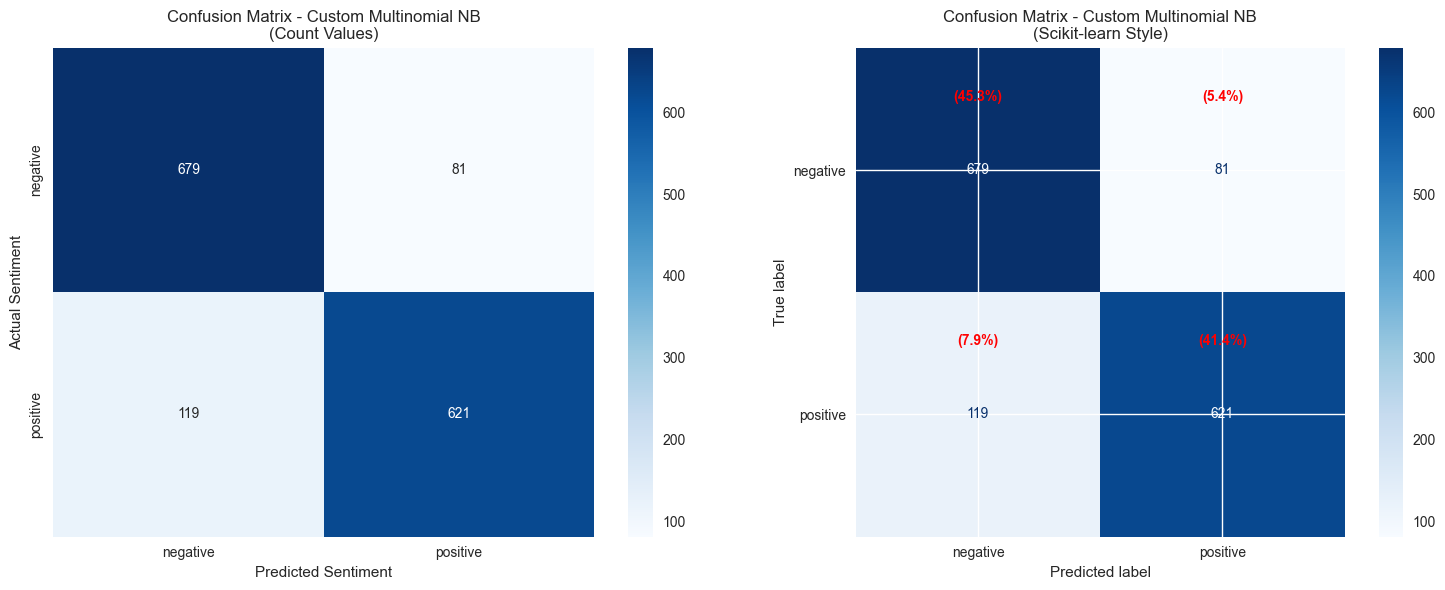


PERFORMANCE INTERPRETATION:
--------------------------------------------------
• True Positives (Positive → Positive): 621
• True Negatives (Negative → Negative): 679
• False Positives (Negative → Positive): 81
• False Negatives (Positive → Negative): 119
• False Positive Rate: 0.1066 (10.66%)
• False Negative Rate: 0.1608 (16.08%)
• Total Misclassified: 200 out of 1500 samples
• Accuracy: 0.8667 (86.67%)


In [9]:
# Confusion Matrix Visualization

print("CONFUSION MATRIX VISUALIZATION:")
print("-" * 40)

# Create a more detailed confusion matrix plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Seaborn heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=custom_nb_model.classes, 
            yticklabels=custom_nb_model.classes, 
            ax=ax1)
ax1.set_xlabel("Predicted Sentiment")
ax1.set_ylabel("Actual Sentiment")
ax1.set_title("Confusion Matrix - Custom Multinomial NB\n(Count Values)")

# Plot 2: Scikit-learn style with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_nb_model.classes)
disp.plot(cmap="Blues", ax=ax2, values_format='d')
ax2.set_title("Confusion Matrix - Custom Multinomial NB\n(Scikit-learn Style)")

# Add percentage annotations to the second plot
for i in range(len(custom_nb_model.classes)):
    for j in range(len(custom_nb_model.classes)):
        percentage = (cm[i, j] / total_samples) * 100
        ax2.text(j, i-0.3, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

# Performance interpretation
print(f"\nPERFORMANCE INTERPRETATION:")
print("-" * 50)

# Calculate error rates
if len(custom_nb_model.classes) == 2:  # Binary classification
    tn, fp, fn, tp = cm.ravel()
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (fn + tp)
    
    print(f"• True Positives (Positive → Positive): {tp}")
    print(f"• True Negatives (Negative → Negative): {tn}")
    print(f"• False Positives (Negative → Positive): {fp}")
    print(f"• False Negatives (Positive → Negative): {fn}")
    print(f"• False Positive Rate: {false_positive_rate:.4f} ({false_positive_rate*100:.2f}%)")
    print(f"• False Negative Rate: {false_negative_rate:.4f} ({false_negative_rate*100:.2f}%)")

print(f"• Total Misclassified: {total_samples - int(accuracy * total_samples)} out of {total_samples} samples")
print(f"• Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

In [10]:
# Final Model Performance Summary

print("=" * 70)
print("FINAL MODEL ACCURACY SUMMARY")
print("=" * 70)
print(f"\nMODEL ACCURACY: {accuracy:.6f}")
print(f"PERCENTAGE ACCURACY: {accuracy*100:.4f}%")
print(f"CORRECT PREDICTIONS: {int(accuracy * total_samples)} out of {total_samples}")
print(f"INCORRECT PREDICTIONS: {total_samples - int(accuracy * total_samples)} out of {total_samples}")

# Show some prediction examples with confidence scores
print(f"\nSAMPLE PREDICTIONS WITH CONFIDENCE SCORES:")
print("-" * 60)

# Set random seed for reproducible results
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), 5, replace=False)

for i, idx in enumerate(sample_indices):
    sample_text = X_test.iloc[idx]
    actual = y_test.iloc[idx]
    
    # Get prediction and probabilities
    pred = custom_nb_model.predict(X_test_vec[idx:idx+1])[0]
    probs = custom_nb_model.predict_proba(X_test_vec[idx:idx+1])[0]
    
    print(f"\nSample {i+1}: (Index {idx})")
    print(f"  Text: '{sample_text[:100]}...'")
    print(f"  Actual: {actual}")
    print(f"  Predicted: {pred}")
    print(f"  Confidence: ", end="")
    
    for j, class_label in enumerate(custom_nb_model.classes):
        print(f"{class_label}={probs[j]:.4f} ", end="")
    
    status = "CORRECT" if pred == actual else "WRONG"
    print(f" → {status}")

print("\n" + "=" * 70)
print("SENTIMENT ANALYSIS EVALUATION COMPLETE")
print("Custom Multinomial Naive Bayes Performance:")
print(f"- Accuracy: {accuracy:.4f}")
print(f"- Precision (Weighted): {weighted_precision:.4f}")
print(f"- Recall (Weighted): {weighted_recall:.4f}")
print(f"- F1-Score (Weighted): {weighted_f1:.4f}")
print("=" * 70)

FINAL MODEL ACCURACY SUMMARY

MODEL ACCURACY: 0.866667
PERCENTAGE ACCURACY: 86.6667%
CORRECT PREDICTIONS: 1300 out of 1500
INCORRECT PREDICTIONS: 200 out of 1500

SAMPLE PREDICTIONS WITH CONFIDENCE SCORES:
------------------------------------------------------------

Sample 1: (Index 1116)
  Text: 'released in december of sayonara went on to earn oscar nominations and would pull in wins red button...'
  Actual: positive
  Predicted: positive
  Confidence: negative=0.1828 positive=0.8172  → CORRECT

Sample 2: (Index 1368)
  Text: 'two hours ago i was watching this brilliant movie which overwhelmed me with its imprisoning photogra...'
  Actual: positive
  Predicted: positive
  Confidence: negative=0.2258 positive=0.7742  → CORRECT

Sample 3: (Index 422)
  Text: 'it is incredible that there were two films with the same story released in this one came out a day b...'
  Actual: negative
  Predicted: negative
  Confidence: negative=0.5741 positive=0.4259  → CORRECT

Sample 4: (Index 413)
  T